# Text Analysis - Word Documents & Web Pages

Skip to:

* [Web Pages](#web)
* [Word Documents](#word)

## __Copy Me!__

First things first - more than one person working with a particular notebook will cause problems. For the purposes of this workshop, please make a copy and rename to prevent confusion.

1. From the _File_ menu, select _Make a copy_
2. This will open up a new notebook - please rename it before proceeding
3. From the _File_ menu, select _Rename..._.
4. Make the new name as unambiguous as possible.

## Credit

Thanks to Wendy Pedersen for the sample data!

Some of the code which follows has been adapted from:

_Collocations_, accessed June 8, 2017. http://www.nltk.org/howto/collocations.html

## Install Dependencies

If you are using Anaconda, which is recommended, many useful extensions are pre-installed. One of these extensions is _Pip_, which is a commonly used installer for Python libraries and modules. 

If necessary, you can also install Pip manually: [https://packaging.python.org/tutorials/installing-packages/](https://packaging.python.org/tutorials/installing-packages/)

All of the libraries we will be using today have already been installed on the server. In your local or desktop environment, you may need to install any that are not provided by Anaconda. As needed, uncomment the pip commands in the next cell and run it before proceeding.

In [21]:
#!pip install beautifulsoup4
#!pip install nltk
#!pip install wordcloud
#!pip install python-docx
#!pip install requests

## About the Dependencies

### BeautifulSoup

BeautifulSoup is a library for parsing HTML. While it does not retrieve web pages, in combination with an HTTP utility such as _requests_, it is useful for screens-scraping and analysing web content. Specifically, BeautifulSoup provides methods for navigating and extracting text, attributes, and other features from structured (but often messy) HTML.

Documentation: [https://www.crummy.com/software/BeautifulSoup/bs4/doc/](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

### NLTK

_NTLK_ stands for _Natural Language Toolkit_. This is a robust suite of utilities and methods for analysing unstructured text, with capabilities for machine learning, classification, and sentiment analysis.

Documentation: [http://www.nltk.org/](http://www.nltk.org/)

### Wordcloud

An easy to use wordcloud generator. Includes support for bigrams.

Documentation: [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud)

### Python-Docx

A library for reading and writing MS Word files. Just as BeautifulSoup understands the structure of HTML, Docx provides methods for parsing and manipulating the different elements of a Word file (headers, font styles, paragraphs, etc.)

Documentation: [https://python-docx.readthedocs.io/en/latest/](https://python-docx.readthedocs.io/en/latest/)

### Requests

As noted on the website, _HTTP for Humans_. This is a well documented resource for interacting with static web pages, APIs, etc.

Documentation: [http://docs.python-requests.org/en/master/](http://docs.python-requests.org/en/master/)

--------------------------------------------------------------------------------------------------------------------------------

## Doing Stuff

Now that our environment has been set up, we can begin analyzing text. Please note that the for the most part the code provided here is oriented toward analyzing single documents or, at most, a handful of web pages.

In the next cell, we import the first of several libraries. Note that NLTK utilizes multiple extensions and resources such as example corpora and stopword lists. Some of these are not installed with the module and must be installed separately - as above, this has already been done on the server. If using this notebook on a workstation, uncomment the second line before running the next cell.

In [22]:
import nltk
#nltk.download('all')

In the next cell, we import the remaining libraries and modules. Note that import statements are generally provided in the available documentation.

In [23]:
import requests
from bs4 import BeautifulSoup
import string
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from operator import itemgetter
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

# <a name="web"></a> Web Pages

**NOTE: If you skipped here from the top of the page, you may still need to load libraries and etc. From the _Cell_ menu, select _Run All Above_**.

From here on, more useful information may be presented in comments in the code blocks. But as an overview, the next several cells provide a process for harvesting HTML from web pages - screen scraping - separating the text from the HTML element tags, and doing a basic text analysis of the content. The analysis consists of:

1. Word count
2. Bigram (two word phrase or collocation) and trigram (three word phrase or collocation) analysis
3. Word cloud

The process makes use of the following libraries: Requests, BeautifulSoup, NLTK, Wordcloud.

In [24]:
# The 'libguides' variable is a comma separated list of the web pages we want to scrape. Even if we only want to harvest
# a single web page, using a list is a good idea because it simplifies the process of adding or updating pages later.

libguides = ['http://libguides.unm.edu/Special_LatinAmerican_Collections/Colonial_Spanish_American_Manuscripts',
            'http://libguides.unm.edu/Special_LatinAmerican_Collections/Modern_Mexico_Guatemala_Manuscripts',
            'http://libguides.unm.edu/Special_LatinAmerican_Collections/Visual_Manuscripts']

# The 'collDescriptions' variable is also a list. List items will consist of text from the web page, specifically in the
# example case, list items will be link description fields as utilized in Springer's Libguides platform.

# For our purposes we could have used other data structures, but I like a list because it allows us to keep the individual
# descriptions separate from each other yet makes it easy to combine them as needed. Note also that the list is empty - it's
# often useful to initialize an empty list and add items to it later.

collDescriptions = []

# The next block of code is a 'for' loop. In plain language, it says:
# for each libguide/web page in the list of libguide pages...
#      request the page and store the response in a new 'libguide' variable
#      parse the response into HTML and store in a new 'soup' variable
#      extract out just the link descriptions and store in a new 'descriptions' variable (which is a list!)
#      for each collection description in the list of descriptions:
#           append the collection description to the global list of collection descriptions

# Why do we have two lists of collection descriptions? Context - "collDescriptions" is a list of all of the 
# collection descriptions across all of the web pages we're harvesting. "descriptions" is a list of collection
# descriptions from a single page. Because of the 'for' loop, every time we harvest a new page, the 'descriptions'
# list is overwritten.

for guide in libguides:
    libguide = requests.get(guide)
    soup = BeautifulSoup(libguide.text, 'html.parser')
    # To harvest a different kind of page than a libguide, or to get some other
    # info out of a libguide, the next line needs to be edited.
    # A generic option is provided in the next line - uncomment and comment the libguide specific line as needed.
    #descriptions = soup.find('p').getText() # If this line is used, remove '.string' from the last line below.
    descriptions = soup.find_all(attrs={"class": "s-lg-link-desc"})
    for collection in descriptions:
        collDescriptions.append(collection.string)
#collDescriptions

## Single Word Count

All of our text is currently in a list. To do basic word and ngram analysis, we need to convert the list into a text corpus. There are various ways to do this, but for simplicity's sake we are going to combine all of the descriptions into one long string. "String" is a data type - think of it as generic text.

In [25]:
# Declare a new "collCorpus" variable. At first it is an empty string. 
# The 'for' loop iterates through the global list of collection descriptions and appends the text
# to the "collCorpus" string. If we were to print or view "collCorpus" afterwardss, it would look
# like a long, unformatted paragraph.

collCorpus = ''
for description in collDescriptions:
    collCorpus = collCorpus + str(description)

# The next two lines tokenize the corpus - that is, the long unformatted string is converted into
# a list of individual words. The process also removes additional whitespace. The tokenized text data
# are stored in a new variable, 'cDataNoWS' ('corpus data, no whitespace').

tokenizer = RegexpTokenizer(r'\w+')
cDataNoWS = tokenizer.tokenize(collCorpus)

# The next two lines use methods from the Counter module to normalize words (tokens) in the corpus
# and bypass stopwords. The second line generates the word count.

word_count_dict = Counter(w.title() for w in cDataNoWS if w.lower() not in stopwords.words())
word_count_dict.most_common()

[('Collection', 65),
 ('Mexico', 64),
 ('Contains', 30),
 ('Documents', 25),
 ('Materials', 24),
 ('Mexican', 23),
 ('Spanish', 22),
 ('America', 19),
 ('Latin', 17),
 ('New', 17),
 ('Include', 15),
 ('Consists', 15),
 ('Photographs', 14),
 ('Political', 14),
 ('Research', 14),
 ('Material', 12),
 ('Posters', 12),
 ('Century', 12),
 ('Archivo', 11),
 ('Included', 11),
 ('Correspondence', 11),
 ('Art', 11),
 ('Colonial', 11),
 ('Spain', 11),
 ('Prints', 10),
 ('Government', 10),
 ('Series', 9),
 ('Book', 9),
 ('Notes', 9),
 ('Many', 9),
 ('Life', 8),
 ('Including', 8),
 ('One', 8),
 ('Photos', 8),
 ('Years', 8),
 ('Social', 8),
 ('Land', 8),
 ('History', 7),
 ('Nicaragua', 7),
 ('American', 7),
 ('General', 7),
 ('Related', 7),
 ('City', 7),
 ('Posada', 7),
 ('José', 7),
 ('Cuba', 6),
 ('Records', 6),
 ('Number', 6),
 ('Religious', 6),
 ('Information', 6),
 ('Includes', 6),
 ('Music', 6),
 ('Legal', 6),
 ('Various', 6),
 ('Archives', 6),
 ('Randall', 6),
 ('Mapa', 6),
 ('Central', 6),
 

## Bigram Analysis

A bigram is a two-word phrase. Below, we analyze the tokenized corpus data for bigrams and filter out stopwords. The stopword list is whatever is provided by default by NLTK.

Results are further filtered to limit the list of bigrams to those which occur three or more times.

In [26]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(cDataNoWS)
finder.apply_freq_filter(3)
ignored_words = nltk.corpus.stopwords.words('english')
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
finder.nbest(bigram_measures.likelihood_ratio, 100)

[('Latin', 'America'),
 ('collection', 'contains'),
 ('New', 'Mexico'),
 ('United', 'States'),
 ('Archivo', 'General'),
 ('Also', 'included'),
 ('colonial', 'history'),
 ('Margaret', 'Randall'),
 ('Guadalupe', 'Posada'),
 ('José', 'Guadalupe'),
 ('Mexico', 'City'),
 ('Casino', 'Luís'),
 ('Communist', 'Party'),
 ('Luís', 'Mier'),
 ('Teatro', 'Casino'),
 ('Puerto', 'Rican'),
 ('human', 'rights'),
 ('South', 'America'),
 ('writings', 'focus'),
 ('Madrid', 'Archivo'),
 ('nineteenth', 'century'),
 ('Latin', 'American'),
 ('wide', 'variety'),
 ('collection', 'consists'),
 ('century', 'Mexican'),
 ('research', 'materials'),
 ('contains', 'material'),
 ('Spanish', 'documents')]

## Trigram Analysis

A trigram is a three-word phrase. Below, we analyze the tokenized corpus data for trigrams and filter out stopwords. The stopword list is whatever is provided by default by NLTK.

Results are further filtered to limit the list of trigrams to those which occur three or more times.

In [27]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
triFinder = TrigramCollocationFinder.from_words(cDataNoWS)
triFinder.apply_freq_filter(3)
ignored_words = nltk.corpus.stopwords.words('english')
triFinder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
triFinder.nbest(trigram_measures.likelihood_ratio, 50)

[('José', 'Guadalupe', 'Posada'),
 ('Casino', 'Luís', 'Mier'),
 ('Teatro', 'Casino', 'Luís')]

## Word Cloud

Here we generate a word cloud, which as noted can include bigrams (see 'New Mexico' and "Latin America' in our example).

For those interested in exploring and working with an API, the Wordcloud reference at [http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud) is thorough yet manageable.

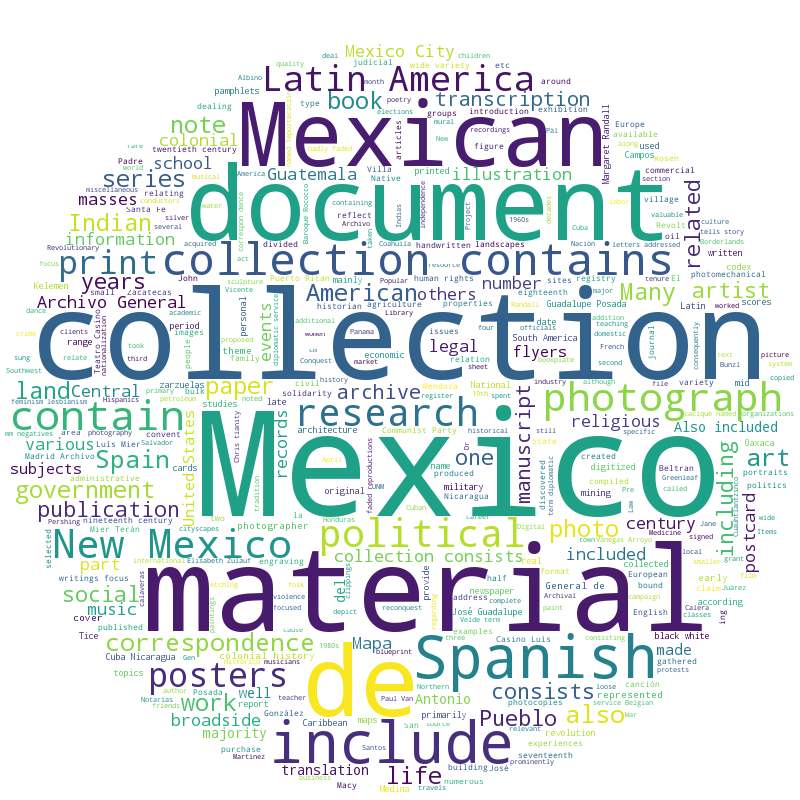

In [28]:
# The next block create a WordCloud object and passes multiple arguments including the number of words to include in the
# word cloud ('max_words'). All of the arguments have defaults, which for practical purposes means that none are required.

# Also note - a 'mask' is not needed, but the resulting word cloud is less aesthectically pleasing.

wordcloud = WordCloud(max_words=500,
                      min_font_size=6,
                      background_color='#ffffff',
                      mask=imread('cloud_mask_1.png')
                     )
wordcloud.generate_from_text(collCorpus)
wordcloud.to_image()



### A Note on Stopwords

The Wordcloud module comes with its own set of stopwords (note here that 'set' is a specific data structure and shouldn't be confused with a list). For some purposes we want to be able to expand or customize the set of stopwords - see in the example above, 'collection contains,' which is common to our collection descriptions but not of particular interest in our results. 

In the next cell, we create another word cloud but this time we're going to use NLTK's defaul set of English stopwords and add some of our own. (Thanks to Karl for the code!)

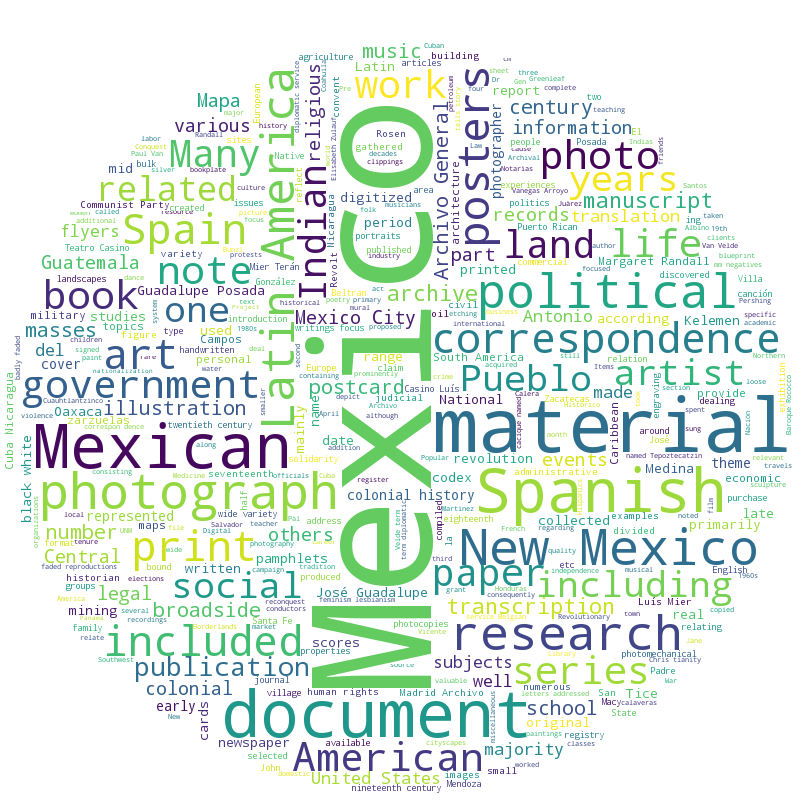

In [29]:
from nltk.corpus import stopwords
from operator import itemgetter

# Get NLTK set of English stopwords
stop = set(stopwords.words('english'))

# Define some additional characters to exclude. Note that these are sets.
punctuation = set(u".,;:()'\"[]{}<>?!=/#%&$12345678910")
annoyances = set({u'``',u"''",u'\x9d',u"'s"})

# Declare a set of stopwords specific to our example.
# It is likely that stemming is supported, so we wouldn't have to include every variation of
# words like contain, contains, etc. 
additional = set({'collection', 'contains', 'also', 'contain', 'consists', 'include', 'includes', 'de'})

# Create a new set which includes all of the stopword sets above.
fullstop = sorted((stop | punctuation | annoyances | additional), key=itemgetter(0))

# The rest is the same as above, except that we reference our customized stopword list.
wordcloud = WordCloud(max_words=500,
                      min_font_size=6,
                      background_color='#ffffff',
                      mask=imread('cloud_mask_1.png'),
                      stopwords=fullstop
                     )
wordcloud.generate_from_text(collCorpus)
wordcloud.to_image()

# <a name="word"></a> Word Documents

**NOTE: If you skipped here from the top of the page, you may still need to load libraries and etc. From the _Cell_ menu, select _Run All Above_**.


From here on, more useful information may be presented in comments in the code blocks. But as an overview, the next several cells provide a process for a basic text analysis of the content of a MS Word document. The analysis consists of:

1. Word count
2. Bigram (two word phrase or collocation) and trigram (three word phrase or collocation) analysis
3. Word cloud

The process makes use of the following libraries: Python-Docx, NLTK, Wordcloud.

As noted above, the python-docx library is able to parse out the many elements of a Word document - formatting info, fonts, headers, etc. As with our HTML example above, for demo purposes we will keep things simple and only use paragraph text.

In [30]:
# Import the library and load a Word file into memory. Thanks to Wendy for the sample Word file!

import docx
doc = docx.Document('Libguidetexts.docx')

In [31]:
# Similar to the process used above, create an empty list. Iterate through the paragraphs in the document
# and append the paragraph text to the list.

fullText = []
for para in doc.paragraphs:
    fullText.append(para.text)
#fullText

## Single Word Count

All of our text is currently in a list. To do basic word and ngram analysis, we need to convert the list into a text corpus. There are various ways to do this, but for simplicity's sake we are going to combine all of the descriptions into one long string. "String" is a data type - think of it as generic text.

In [32]:
# Build a corpus string, also similar to the above HTML example. Because the source document includes several
# additional carriage returns between paragraphs, add a condition to check for and bypass empty paragraphs.

collCorpus2 = ''
for p in range(5, len(fullText)):
    t = fullText[p]
    if t != ' ':
        collCorpus2 = collCorpus2 + str(t)

# The next two lines tokenize the corpus - that is, the long unformatted string is converted into
# a list of individual words. The process also removes additional whitespace. The tokenized text data
# are stored in a new variable, 'wordDataNoWS' ('word data, no whitespace').
        
tokenizer = RegexpTokenizer(r'\w+')
wordDataNoWS = tokenizer.tokenize(collCorpus2)

# The next two lines use methods from the Counter module to normalize words (tokens) in the corpus
# and bypass stopwords. The second line generates the word count.

word_count_dict = Counter(w.title() for w in wordDataNoWS if w.lower() not in stopwords.words())
word_count_dict.most_common()

[('Collection', 63),
 ('Mexico', 43),
 ('Contains', 30),
 ('Documents', 24),
 ('Mexican', 23),
 ('Spanish', 22),
 ('Materials', 21),
 ('Include', 15),
 ('Nm', 15),
 ('Consists', 15),
 ('Photographs', 14),
 ('Political', 14),
 ('Research', 14),
 ('Latinamerica', 13),
 ('Correspondence', 12),
 ('Colonial', 12),
 ('Posters', 12),
 ('Century', 12),
 ('Material', 11),
 ('Archivo', 11),
 ('Art', 11),
 ('Spain', 11),
 ('Included', 10),
 ('Prints', 10),
 ('Series', 9),
 ('Notes', 9),
 ('Book', 9),
 ('Many', 9),
 ('Life', 8),
 ('Social', 8),
 ('Land', 8),
 ('One', 8),
 ('Photos', 8),
 ('Years', 8),
 ('Including', 8),
 ('Government', 8),
 ('History', 7),
 ('Nicaragua', 7),
 ('Information', 7),
 ('General', 7),
 ('Related', 7),
 ('Posada', 7),
 ('Guatemala', 7),
 ('José', 7),
 ('Records', 6),
 ('Number', 6),
 ('Others', 6),
 ('Archives', 6),
 ('Includes', 6),
 ('Randall', 6),
 ('Mapa', 6),
 ('Various', 6),
 ('Papers', 6),
 ('Transcriptions', 6),
 ('Music', 6),
 ('Cuba', 6),
 ('Religious', 6),
 ('

## Bigram Analysis

A bigram is a two-word phrase. Below, we analyze the tokenized corpus data for bigrams and filter out stopwords. The stopword list is whatever is provided by default by NLTK.

Results are further filtered to limit the list of bigrams to those which occur three or more times.

In [33]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(wordDataNoWS)
finder.apply_freq_filter(3)
ignored_words = nltk.corpus.stopwords.words('english')
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
finder.nbest(bigram_measures.likelihood_ratio, 100)

[('collection', 'contains'),
 ('United', 'States'),
 ('Archivo', 'General'),
 ('Also', 'included'),
 ('colonial', 'history'),
 ('Margaret', 'Randall'),
 ('Guadalupe', 'Posada'),
 ('José', 'Guadalupe'),
 ('Casino', 'Luís'),
 ('Communist', 'Party'),
 ('Luís', 'Mier'),
 ('Teatro', 'Casino'),
 ('Puerto', 'Rican'),
 ('human', 'rights'),
 ('writings', 'focus'),
 ('Madrid', 'Archivo'),
 ('nineteenth', 'century'),
 ('wide', 'variety'),
 ('collection', 'consists'),
 ('research', 'materials'),
 ('century', 'Mexican'),
 ('contains', 'material'),
 ('Spanish', 'documents')]

## Trigram Analysis

A trigram is a three-word phrase. Below, we analyze the tokenized corpus data for trigrams and filter out stopwords. The stopword list is whatever is provided by default by NLTK.

Results are further filtered to limit the list of trigrams to those which occur three or more times.

In [34]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
triFinder = TrigramCollocationFinder.from_words(wordDataNoWS)
triFinder.apply_freq_filter(3)
ignored_words = nltk.corpus.stopwords.words('english')
triFinder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
triFinder.nbest(trigram_measures.likelihood_ratio, 50)

[('José', 'Guadalupe', 'Posada'),
 ('Casino', 'Luís', 'Mier'),
 ('Teatro', 'Casino', 'Luís')]

## Word Cloud

Here we generate a word cloud, which as noted can include bigrams (see 'New Mexico' and "Latin America' in our example).

For those interested in exploring and working with an API, the Wordcloud reference at [http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud) is thorough yet manageable.

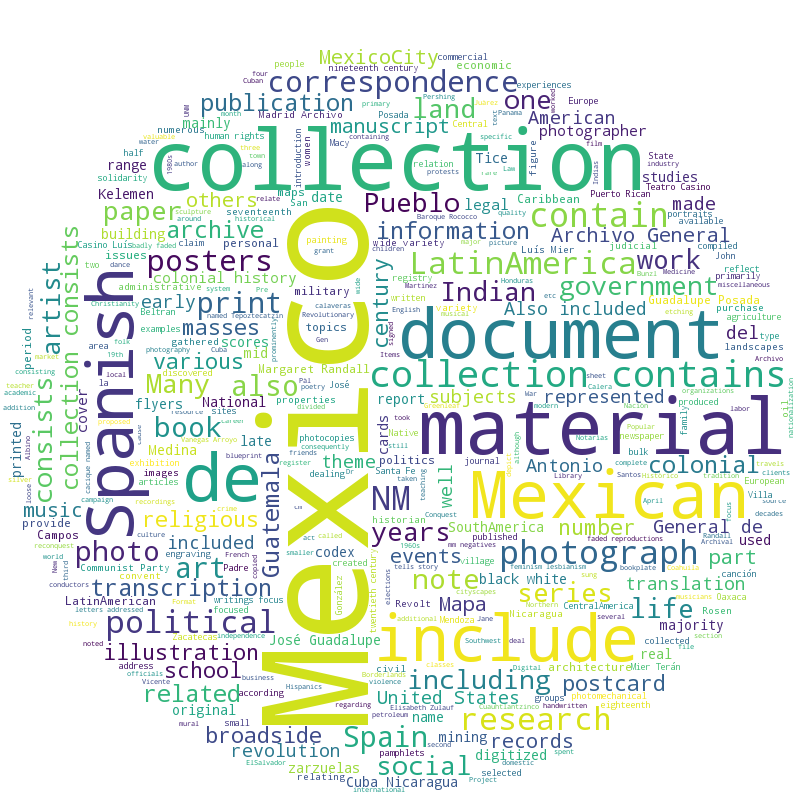

In [35]:
# The next block create a WordCloud object and passes multiple arguments including the number of words to include in the
# word cloud ('max_words'). All of the arguments have defaults, which for practical purposes means that none are required.

# Also note - a 'mask' is not needed, but the resulting word cloud is less aesthectically pleasing.

wordcloud = WordCloud(max_words=500,
                      min_font_size=6,
                      background_color='#ffffff',
                      mask=imread('cloud_mask_1.png')
                     )
wordcloud.generate_from_text(collCorpus2)
wordcloud.to_image()


### A Note on Stopwords

The Wordcloud module comes with its own set of stopwords (note here that 'set' is a specific data structure and shouldn't be confused with a list). For some purposes we want to be able to expand or customize the set of stopwords - see in the example above, 'collection contains,' which is common to our collection descriptions but not of particular interest in our results. 

In the next cell, we create another word cloud but this time we're going to use NLTK's defaul set of English stopwords and add some of our own. (Thanks to Karl for the code!)

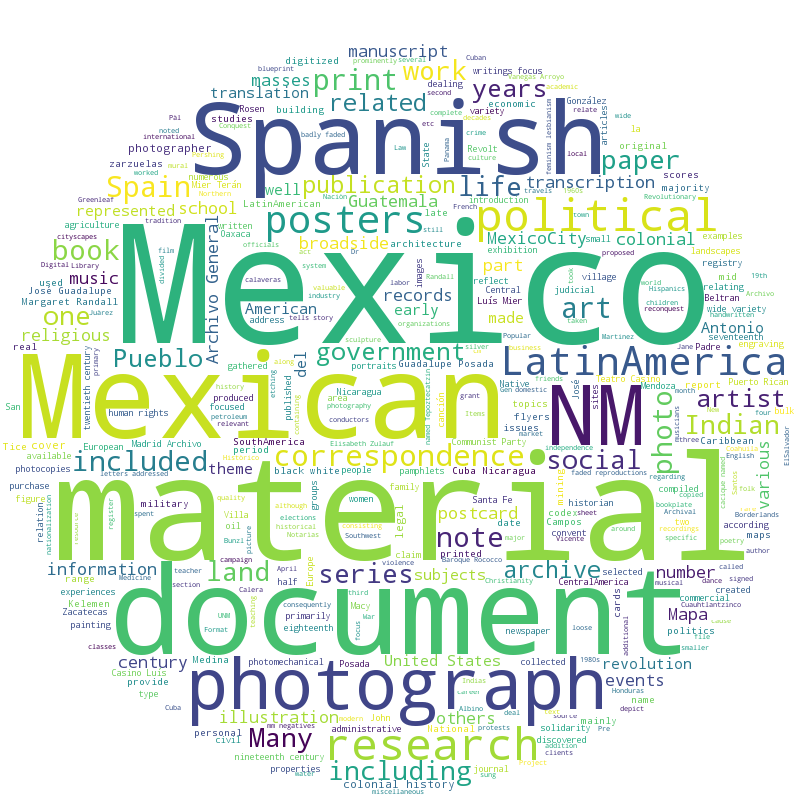

In [37]:
from nltk.corpus import stopwords
from operator import itemgetter

# Get NLTK set of English stopwords
stop = set(stopwords.words('english'))

# Define some additional characters to exclude. Note that these are sets.
punctuation = set(u".,;:()'\"[]{}<>?!=/#%&$12345678910")
annoyances = set({u'``',u"''",u'\x9d',u"'s"})

# Declare a set of stopwords specific to our example.
# It is likely that stemming is supported, so we wouldn't have to include every variation of
# words like contain, contains, etc. 
additional = set({'collection', 'contains', 'also', 'contain', 'consists', 'include', 'includes', 'de'})

# Create a new set which includes all of the stopword sets above.
fullstop = sorted((stop | punctuation | annoyances | additional), key=itemgetter(0))

# The rest is the same as above, except that we reference our customized stopword list.
wordcloud = WordCloud(max_words=500,
                      min_font_size=6,
                      background_color='#ffffff',
                      mask=imread('cloud_mask_1.png'),
                      stopwords=fullstop
                     )
wordcloud.generate_from_text(collCorpus2)
wordcloud.to_image()